In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import List, Tuple
import collections
from collections import namedtuple, deque
import tqdm
import os
import matplotlib.pyplot as plt
import random
import gymnasium as gym

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(16, 16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 16)
        self.activation3 = nn.ReLU()
        self.output_layer = nn.Linear(16, output_size)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_layer(x)
        return x

In [5]:
class QNetwork(nn.Module):  # Inherit from nn.Module
    def __init__(self, input_size, output_size, learning_rate, log_dir=None, device=torch.device('cpu')):
        super(QNetwork, self).__init__()
        self.device = device
        self.net = NeuralNetwork(input_size, output_size).to(self.device)
        self.learning_rate = learning_rate 
        self.log_dir = log_dir
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)

class ReplayBuffer:
    def __init__(self, buffer_size=50000, burn_in=10000):
        self.buffer_size = buffer_size
        self.burn_in = burn_in
        self.buffer = collections.deque([], maxlen=buffer_size)

    def sample_batch(self, batch_size=32):
        return random.sample(self.buffer, batch_size)

    def append(self, transition):
        self.buffer.append(transition)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
class DQNAgent:
    def __init__(self, env_name, learning_rate=0.00049, render=False, device=torch.device('cpu')):
        self.device = device
        self.env = gym.make(env_name)
        self.learning_rate = learning_rate
        # Initialize the policy and target networks correctly
        self.policy_net = QNetwork(self.env.observation_space.shape[0], self.env.action_space.n, learning_rate, device=device).to(device)
        self.target_net = QNetwork(self.env.observation_space.shape[0], self.env.action_space.n, learning_rate, device=device).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.replay_buffer = ReplayBuffer(buffer_size=50000, burn_in=10000) 
        self.populate_replay_buffer()
        self.batch_size = 256
        self.discount_factor = 0.98
        self.counter = 37
        self.epsilon_decay = 0.99  # Decayrate
        self.epsilon_min = 0.01  #minimum epsilon value
        self.epsilon = 1.0  # initial epsilon value
        self.epsilons = []  # To store epsilon values during training
        self.losses = []  # To store training losses during training

    def populate_replay_buffer(self):
        count = 0
        terminated = False
        truncated = False
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)

        while count < self.replay_buffer.burn_in:
            if terminated or truncated:
                state, _ = self.env.reset()
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            
            action = torch.tensor(random.sample([0, 1], 1)[0]).reshape(1, 1).to(self.device)
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward], device=self.device)
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)
                
            transition = Transition(state, action, next_state, reward)
            self.replay_buffer.buffer.append(transition)
            state = next_state
            count += 1

    def train(self):
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        terminated = False
        truncated = False

        while not (terminated or truncated):
            with torch.no_grad():
                q_values = self.policy_net.net(state)

            action = self.epsilon_greedy_policy(q_values).reshape(1, 1).to(self.device)
            
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward], device=self.device)
            
            # Check for termination condition based on the environment's definition
            terminated = terminated or (-torch.cos(torch.tensor(next_state[0])) - torch.cos(torch.tensor(next_state[1] + next_state[0])) > 1.0)
            
            if terminated or truncated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)

            transition = Transition(state, action, next_state, reward)
            self.replay_buffer.append(transition)

            state = next_state if next_state is not None else torch.tensor(self.env.reset()[0], dtype=torch.float32).unsqueeze(0).to(self.device)

            transitions = self.replay_buffer.sample_batch(self.batch_size)
            batch = Transition(*zip(*transitions))
            
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool, device=self.device)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            state_action_values = self.policy_net.net(state_batch).gather(1, action_batch)
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target_net.net(non_final_next_states).max(1)[0].detach()
            
            expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

            loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

            self.policy_net.optimizer.zero_grad()
            loss.backward()
            self.policy_net.optimizer.step()

            self.losses.append(loss.item())  # Store the training loss

            self.counter += 1
            if self.counter % 50 == 0:
                self.target_net.net.load_state_dict(self.policy_net.net.state_dict())

        # Epsilon decay
        self.epsilons.append(self.epsilon)
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


                
    def save_model_weights(self, directory="saved_weights"):
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save(self.policy_net.net.state_dict(), os.path.join(directory, "model_weights_cartpole.pth"))

    def epsilon_greedy_policy(self, q_values):

        if random.random() > self.epsilon:
            return q_values.max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(3)]], device=self.device, dtype=torch.long)

    def test(self):
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        total_reward = 0
        terminated = False
        truncated = False

        while not (terminated or truncated):
            with torch.no_grad():
                q_values = self.policy_net.net(state)
                action = q_values.max(1)[1].view(1, 1)  # select the best action
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            total_reward += reward
            if not terminated and not truncated:
                state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)
            else:
                break
        return total_reward

    
    def run_greedy_episodes(self, num_episodes=5):
        greedy_rewards = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            total_reward = 0
            terminated = False
            truncated = False

            while not (terminated or truncated):
                with torch.no_grad():
                    q_values = self.policy_net.net(state)
                    action = q_values.max(1)[1].view(1, 1)
                next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                total_reward += reward
                if not terminated and not truncated:
                    state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)
                else:
                    break
            greedy_rewards.append(total_reward)
        return greedy_rewards


In [7]:
computing_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
rl_agent = DQNAgent("Acrobot-v1", device=computing_device)

num_training_episodes = 2000 
num_testing_episodes = 100 

print("Training Started")
evaluation_rewards = [] 

for episode in range(num_training_episodes):
    rl_agent.train()

    if episode % 10 == 0:
        test_reward = rl_agent.test()
        evaluation_rewards.append(test_reward)
        print(f"Episode {episode}, Test Reward: {test_reward}")

        if len(evaluation_rewards) >= 100:
            average_evaluation_reward = sum(evaluation_rewards[-100:]) / 100
            print(f"Average reward over the last 100 evaluation episodes: {average_evaluation_reward}")

            if average_evaluation_reward > -120:
                print("Environment solved during training evaluation!")
                break
rl_agent.save_model_weights()


print("Testing Started")
test_rewards = []
for episode in range(num_testing_episodes):
    reward = rl_agent.test()
    test_rewards.append(reward)

average_test_reward = sum(test_rewards) / len(test_rewards)
print(f"Average Test Reward: {average_test_reward}")


Training Started
Episode 0, Test Reward: -500.0
Episode 10, Test Reward: -79.0
Episode 20, Test Reward: -139.0
Episode 30, Test Reward: -112.0
Episode 40, Test Reward: -96.0
Episode 50, Test Reward: -130.0
Episode 60, Test Reward: -93.0
Episode 70, Test Reward: -103.0
Episode 80, Test Reward: -84.0
Episode 90, Test Reward: -92.0
Episode 100, Test Reward: -294.0
Episode 110, Test Reward: -139.0
Episode 120, Test Reward: -104.0
Episode 130, Test Reward: -500.0
Episode 140, Test Reward: -71.0
Episode 150, Test Reward: -80.0
Episode 160, Test Reward: -93.0
Episode 170, Test Reward: -87.0
Episode 180, Test Reward: -89.0
Episode 190, Test Reward: -158.0
Episode 200, Test Reward: -84.0
Episode 210, Test Reward: -69.0
Episode 220, Test Reward: -153.0
Episode 230, Test Reward: -94.0
Episode 240, Test Reward: -90.0
Episode 250, Test Reward: -69.0
Episode 260, Test Reward: -67.0
Episode 270, Test Reward: -70.0
Episode 280, Test Reward: -74.0
Episode 290, Test Reward: -70.0
Episode 300, Test Rewar

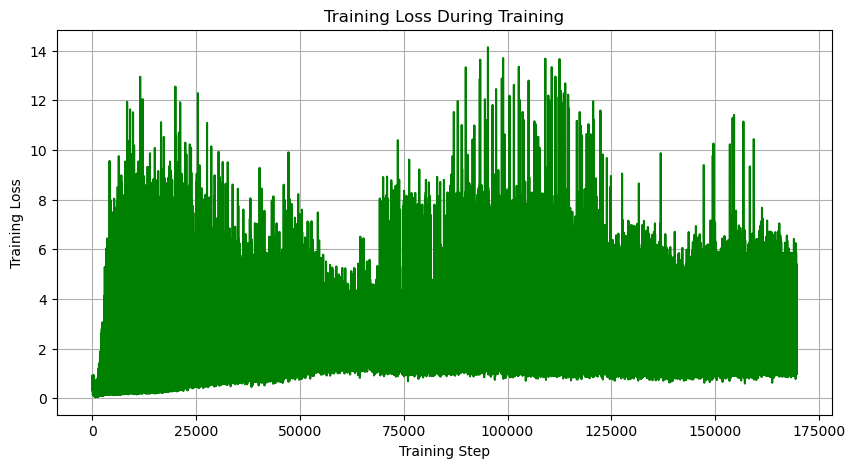

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(rl_agent.losses)), rl_agent.losses, color='g')
plt.title("Training Loss During Training")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

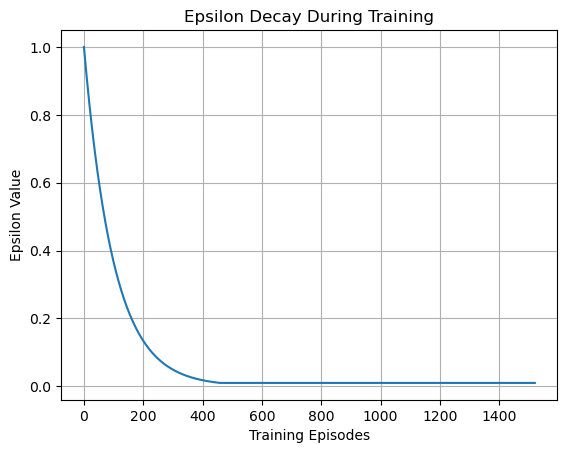

In [9]:
plt.plot(range(len(rl_agent.epsilons)), rl_agent.epsilons)
plt.xlabel('Training Episodes')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay During Training')
plt.grid(True)
plt.show()

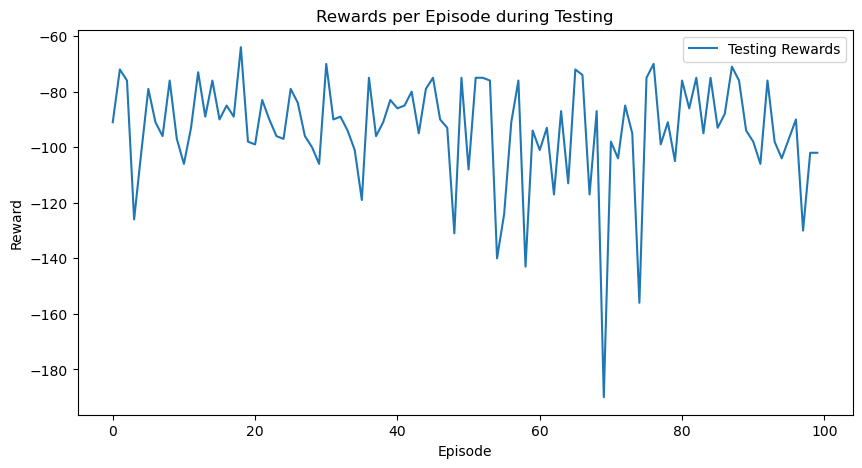

In [10]:
# Plot testing rewards
plt.figure(figsize=(10, 5))
plt.plot(test_rewards, label='Testing Rewards')
plt.title('Rewards per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

Greedy Episode Rewards: [-96.0, -71.0, -75.0, -93.0, -85.0]


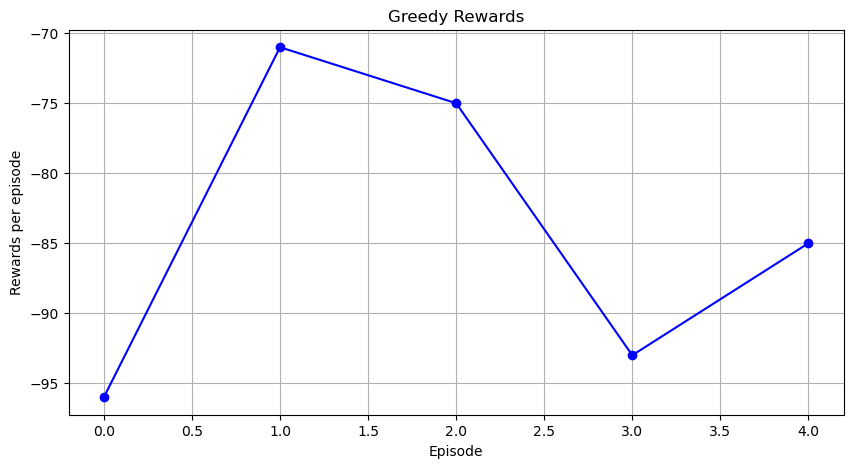

In [11]:
greedy_rewards = rl_agent.run_greedy_episodes(num_episodes=5)
print("Greedy Episode Rewards:", greedy_rewards)
plt.figure(figsize=(10, 5))  # Set the figure size for better readability
plt.plot(range(0, 5), greedy_rewards, marker='o', linestyle='-', color='b')
plt.title("Greedy Rewards")
plt.xlabel("Episode")
plt.ylabel("Rewards per episode")
plt.grid(True)
plt.show()